In [ ]:
!pip install rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import rarfile

with rarfile.RarFile('/content/drive/MyDrive/confident-unconfident.rar') as rf:
    rf.extractall()

In [ ]:
#code for data cleaning

import cv2
from mtcnn import MTCNN
import os
import shutil

# Set the path to the directory containing the images
data_dir = '/content/face/confident'

# Create an instance of the MTCNN model
detector = MTCNN()

# Create a new directory to store the filtered images
filtered_dir = os.path.join(data_dir, 'filtered_conf')
os.makedirs(filtered_dir, exist_ok=True)

# Loop through each image in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Read the image file
        img_path = os.path.join(data_dir, filename)
        img = cv2.imread(img_path)
        # Detect faces in the image
        faces = detector.detect_faces(img)
        # Check if the image contains any faces
        if len(faces) == 0:
            # If there are no faces, move the image to the filtered directory
            shutil.move(img_path, os.path.join(filtered_dir, filename))
            print(f"{filename} moved to filtered directory")


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG19
import os
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Define paths for train, val and test sets
train_data_dir = '/content/confident-unconfident/train'
validation_data_dir = '/content/confident-unconfident/val'
test_data_dir = '/content/confident-unconfident/test'

# Define image dimensions and batch size
img_height = 128
img_width = 128
batch_size = 32
num_classes=2

# Load train, val and test sets

train_datagen = ImageDataGenerator(
    rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')


# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

'''
# Define the model architecture
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  #my inference remove dropout layer because may be my model required more feature
model.add(Dense(num_classes, activation='softmax'))
'''
# Define the optimizer with a specific learning rate
#Optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


# Define callbacks
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator,
                    callbacks=[tensorboard_callback, early_stopping_callback])


#Save the model
model.save('/content/final_model.h5')







Found 22354 images belonging to 2 classes.
Found 6014 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        1846

Found 2000 images belonging to 2 classes.
2000/2000 [==============================] - 28s 14ms/step
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1000
           1       0.73      0.75      0.74      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



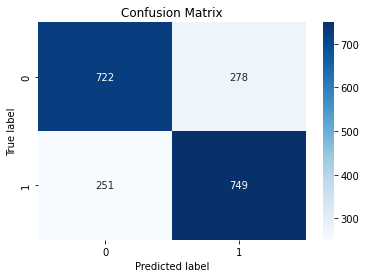

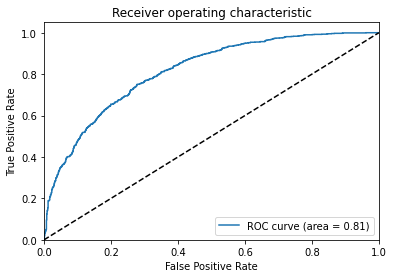

In [23]:
#to plot evaluation matrix

# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test data directory and image dimensions
test_data_dir = '/content/confident-unconfident/test'
img_width, img_height = 128, 128  # replace with your image dimensions

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data from directory using flow_from_directory method
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        shuffle=False,
        class_mode='binary',
        color_mode='grayscale')

# Load the saved model
model = tf.keras.models.load_model('/content/new_model_grey.h5')

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred).astype(int)

# Get the true labels of the test data
y_true = test_generator.classes


print(classification_report(y_true, y_pred_classes))
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# create heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.show()


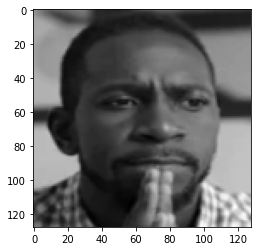

1/1 [==============================] - 0s 154ms/step
[[0.39220804]]
Predicted class is unconfident


In [32]:
from tensorflow import keras
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

model = keras.models.load_model('/content/new_model_grey.h5')
model.compile()

img = cv2.imread("/content/Capture1.png")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
gray_img = np.expand_dims(gray_img, axis=-1) # add a third dimension
resize = tf.image.resize(gray_img, (128, 128))
plt.imshow(resize.numpy().astype(int), cmap='gray') # show the grayscale image
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat >= 0.50:
    print(f'Predicted class is confident')
else:
    print(f'Predicted class is unconfident')

